# AI back test methods1

# --2 fonctions and dependancys


In [ ]:
#! python3 -m pip install --upgrade pip
#! pip install mplfinance
from xdata_config import *
from functions_module import *
import mplfinance as mpf
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import MaxNorm
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense 
from keras.models import load_model
from datetime import datetime

In [ ]:
import requests

url = 'https://api.binance.com/api/v3/ticker/price'

response = requests.get(url)
tickers = response.json()
ticker_list=[]
for ticker in tickers:
    ticker_list.append((ticker['symbol']))


# --1 Config

In [ ]:
# ai_options
Normalization_File= "False"
Model_FileName= "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re4.h5"
WINDOW_SIZE= 7
PRESSISION=0.0
PERIODE_START="09-02-2023 00:00:00"
PERIODE_END="11-02-2023 00:00:00"

start_period = datetime.strptime(PERIODE_START, '%d-%m-%Y %H:%M:%S')
end_period = datetime.strptime(PERIODE_END, '%d-%m-%Y %H:%M:%S')


#trading_options:
TAKE_PROFIT= 0.4  
STOP_LOSS=  0.8 
MAX_HOLDING_TIME= 16

USE_TRAILING_STOP_LOSS: False
TRAILING_STOP_LOSS= .002     
TRAILING_TAKE_PROFIT= .002  

PAIR_WITH= "USDT"
TRADE_TOTAL= 100 
TRADE_SLOTS= 5

TRADING_FEE= 0.1
  

# --3 Importing DATA

In [ ]:
from datetime import date
#TICKERS = "../Binance-Fast-Trade-Bot/volatile_volume_" + str(date.today()) + ".txt"
TICKERS = "/UltimeTradingBot/Binance-Fast-Trade-Bot/halal_coins.txt"
VOLATILE_COINS=[line.strip() for line in open(TICKERS)]
PAIR_WITH="USDT"
VOLATILE_USDT_PAIRS=[coin+"/USDT" for coin in VOLATILE_COINS]
VOLATILE_BUSD_PAIRS=[coin+"/BUSD" for coin in VOLATILE_COINS]
for pair in VOLATILE_BUSD_PAIRS:
    if pair.replace('/' ,'') not  in ticker_list:
        print(pair)
        VOLATILE_BUSD_PAIRS.remove(pair)

for pair in VOLATILE_USDT_PAIRS:
    if pair.replace('/', '') not in ticker_list:
        print(pair)
        VOLATILE_USDT_PAIRS.remove(pair)

content = os.listdir('database/DataBackTest/1m')
for pair in VOLATILE_USDT_PAIRS:
    if pair.replace('/', '-')+'.csv' not in content:
        print(pair)
        VOLATILE_USDT_PAIRS.remove(pair)
for pair in VOLATILE_BUSD_PAIRS:
    if pair.replace('/', '-')+'.csv' not in content:
        print(pair)
        VOLATILE_BUSD_PAIRS.remove(pair)

In [ ]:
# coins_to_download=''
# for coin in LISTCOIN:
#     coins_to_download=coins_to_download+" "+coin
# os.system(f"node database/dd_for_backtest.js {coins_to_download} {PAIR_WITH}")#node database/ddargs.js ORN BUSD

In [ ]:
pair_list = VOLATILE_USDT_PAIRS
#tf = '1m'
oldest_pair = "BTC/USDT"
if oldest_pair not in pair_list: pair_list.append(oldest_pair)
df_list1m = {}
df_list1d = {}
df_list1h = {}
df_list5m = {}
df_list15m = {}


for pair in pair_list:
    df = get_backtest_historical(ccxt.binance(), pair, '1m', path="./database/")
    df_list1m[pair] = df.loc[:]

for pair in pair_list:
    df = get_backtest_historical(ccxt.binance(), pair, '1d', path="./database/")
    df_list1d[pair] = df.loc[:]

for pair in pair_list:
    df = get_backtest_historical(ccxt.binance(), pair, '1h', path="./database/")
    df_list1h[pair] = df.loc[:]

for pair in pair_list:
    df = get_backtest_historical(ccxt.binance(), pair, '5m', path="./database/")
    df_list5m[pair] = df.loc[:]

for pair in pair_list:
    df = get_backtest_historical(
        ccxt.binance(), pair, '15m', path="./database/")
    df_list15m[pair] = df.loc[:]
del(df)
df_list = df_list1m
prerr("Data load 100% use df_list1d[\"BTC/USDT\"] for exemple to access")



# --3 Decalring Tables

In [ ]:
import pandas as pd

def create_portfolio_dataframe(num_slots,init_quantity=500, base_currency='usdt'):
    # create an empty DataFrame with the columns we need
    columns = ['date', f'reserve_{base_currency}',f'total_{base_currency}']
    for i in range(num_slots):
        columns += [f'slot{i+1}_symbol', f'slot{i+1}_volume', f'slot{i+1}_bought_{base_currency}', f'slot{i+1}_current_total_{base_currency}']
    df = pd.DataFrame(columns=columns)
    
    # create some sample data
    for date in pd.date_range(PERIODE_START, periods=1):
        data = {'date': date, f'total_{base_currency}': init_quantity}
        # for i in range(num_slots):
        #     symbol = f'coin{i+1}'
        #     volume = (i+1) * 100
        #     bought_currency = base_currency.upper()
        #     bought_value = (i+1) * 500
        #     current_price = (i+1) * 1.5
        #     current_total = volume * current_price
        #     data.update({
        #         f'slot{i+1}_symbol': symbol,
        #         f'slot{i+1}_volume': volume,
        #         f'slot{i+1}_bought_{base_currency}': bought_value,
        #         f'slot{i+1}_current_total_{base_currency}': current_total,
        #     })
        #     data[f'total_{base_currency}'] += current_total
        df = df.append(data, ignore_index=True)
    
    # set the date column as the index of the DataFrame
    df.set_index('date', inplace=True)
    df.iloc[:,0]=np.float64(init_quantity)
    return df.iloc[0:1]


In [ ]:
Portfolio=create_portfolio_dataframe(TRADE_SLOTS,init_quantity=500, base_currency=PAIR_WITH) #pair with plus slots plus total
Order_history= pd.DataFrame(columns= ['Order ID', 'Pair', 'Side', 'Price', 'Quantity', 'Executed', 'Time', 'Status'])
signal_df=pd.DataFrame(columns= ['coin', 'time',"price",'note'])

In [ ]:
def get_top_volumes(start_period,end_period):
    AllTop20Volumes={}
    for day in df_list1d["BTC/USDT"].index:
        if start_period<= day <= end_period:
            Top20vol={}
            for p,df in df_list1d.items():
                if p not in ["EUR/USDT","EUR/BUSD","BTC/USDT","BTC/BUSD"]:
                    try:Top20vol.update({p:(df.loc[day].volume*df.loc[day].close)})
                    except Exception as e :print(f'Time Error wile working on {p}: {e}')
                    #print (Top20vol)
            AllTop20Volumes.update({day:sorted(Top20vol, key=Top20vol.get, reverse=True)[:20]})
    return AllTop20Volumes

In [ ]:
AllTop20Volumes=get_top_volumes(start_period,end_period)


In [ ]:
AllTop20Volumes[pd.Timestamp("2023-02-09")]

In [ ]:
backtest_model=load_model("/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_VeryDeep.h5")

In [ ]:
signal_df=pd.DataFrame(columns= ['coin', 'time',"price",'note'])
for day,TOPLIST in AllTop20Volumes.items():
    for coin in TOPLIST:
        try:
            print(f">>>>>>>>>>> working on {coin} at: {day} :")
            loc_start=df_list1m[coin].index.get_loc(day)
            loc_end=df_list1m[coin].index.get_loc(day+pd.Timedelta('1 day'))
            gc.collect()
            df=mini_expand4(pair=coin,i=loc_start,j=loc_end,window=WINDOW_SIZE,metadata=MetaData,buy_pourcent=TAKE_PROFIT,sell_pourcent=STOP_LOSS,buy_function=buy_test)
            dt=df.iloc[:,:-1].to_numpy(dtype=np.float32)
            predictions_note=backtest_model.predict(dt)
            predictions_round=predictions_note.round()
            dico_signal={"coin":coin,"time":df[predictions_round==1].index.values,"price":df[predictions_round==1]["price"].values,"note":predictions_note[predictions_round==1]}
            df_signal_coin = pd.DataFrame(dico_signal)
            signal_df=pd.concat([signal_df,df_signal_coin])
        except:
            print(f"error at {day} in {coin}")

In [ ]:
coin="XRP/USDT"
day=pd.Timestamp("2023-02-10 00:00:00")
loc_start=df_list1m[coin].index.get_loc(day)
loc_end=df_list1m[coin].index.get_loc(day+pd.Timedelta('1 day'))
gc.collect()
df=mini_expand4(pair=coin,i=loc_start,j=loc_end,window=WINDOW_SIZE,metadata=MetaData,buy_pourcent=TAKE_PROFIT,sell_pourcent=STOP_LOSS,buy_function=buy_test)
dt=df.iloc[:,:-1].to_numpy(dtype=np.float32)
predictions_note=backtest_model.predict(dt)
predictions_round=predictions_note.round()
dico_signal={"coin":coin,"time":df[predictions_round==1].index.values,"price":df[predictions_round==1]["price"].values,"note":predictions_note[predictions_round==1]}
df_signal_coin = pd.DataFrame(dico_signal)
#signal_df=pd.concat([signal_df,df_signal_coin])

In [ ]:
df_signal_coin

In [ ]:
signal_df

In [ ]:
signal_df[signal_df.time==pd.Timestamp("2023-02-09 00:10:00")]

In [ ]:
def is_coin_in_portfolio(symbol,instant):
    for i in range(1,TRADE_SLOTS+1):
        try:
            if (Portfolio[f"slot{i}_symbol"].loc[instant]==symbol):
                return i
        except Exception as e:
            print(f"error :{e}")
    return False

In [ ]:
is_coin_in_portfolio(symbol="JASMY/USDT",instant="2023-02-09 00:10:00")

In [ ]:
signal_df

In [ ]:
#buy order
#sell order
#update_portfolio
#

start_time = start_period
end_time = end_period

for timestamp in pd.date_range(start=start_time, end=end_time, freq='1min'):
    print(timestamp)
    for minute_signal in signal_df[signal_df.time==timestamp]:
        print(minute_signal)
        
        
    

In [ ]:
def mini_expand4(pair="GMT/USDT",i=0,j=10000,window=2,metadata=MetaData,high_weight=1,buy_pourcent=BUY_PERCENT,sell_pourcent=SELL_PERCENT,buy_function=buy_min_up):
    print(f"mini_expand : {pair}")
    Pair_Full=full_expand(df_list1m[pair].iloc[i:j],df_list5m[pair],df_list15m[pair],df_list1h[pair],df_list1d[pair],window)
    BTC_Full=full_expand(
        df_list1m["BTC/USDT"].loc[(Pair_Full.iloc[0].name-pd.Timedelta(str(window) +" d")).round(freq='1 min'):Pair_Full.iloc[len(Pair_Full)-1].name],
        df_list5m["BTC/USDT"],#.loc[(Pair_Full.iloc[0].name-pd.Timedelta(str(window) +" d")).round(freq='5 min'):Pair_Full.iloc[len(Pair_Full)-1].name],
        df_list15m["BTC/USDT"],#.loc[(Pair_Full.iloc[0].name-pd.Timedelta(str(window) +" day")).round(freq='15 min'):Pair_Full.iloc[len(Pair_Full)-1].name],
        df_list1h["BTC/USDT"],#.loc[(Pair_Full.iloc[0].name-pd.Timedelta(str(window) +" day")).round(freq='1 H'):Pair_Full.iloc[len(Pair_Full)-1].name],
        df_list1d["BTC/USDT"],#.loc[(Pair_Full.iloc[0].name-pd.Timedelta(str(window) +" day")).round(freq='1 d'):Pair_Full.iloc[len(Pair_Full)-1].name],
        window)   
    BTC_Full=BTC_Full.add_prefix("BTC_")
    # Merged=pd.merge(Pair_Full, BTC_Full, left_index=True, how='left',
    #         right_index=True, suffixes=('', ''))
    Merged=pd.merge(Pair_Full, BTC_Full, left_index=True, how='inner',
            right_index=True, suffixes=('', ''))
    day_expand(Merged)
    Meta_expand(Merged,metadata,pair)
    #buy_sell(Merged,buy_pourcent=BUY_PERCENT,sell_pourcent=SELL_PERCENT,window=MAX_FORCAST_SIZE)
    buy_function(Merged,buy_pourcent=buy_pourcent,sell_pourcent=sell_pourcent,window=MAX_FORCAST_SIZE)
    Merged["high"]=(Merged["open"]+high_weight*Merged["high"]+Merged["low"]+Merged["close"])/(3+high_weight)
    Merged.rename(columns={"high":"price"},inplace = True)
    Merged["BTC_high"]=(Merged["BTC_open"]+high_weight*Merged["BTC_high"]+Merged["BTC_low"]+Merged["BTC_close"])/(3+high_weight)
    Merged.rename(columns={"BTC_high":"BTC_price"},inplace = True)
    Merged=Merged.drop(columns=["BTC_open","BTC_low","BTC_close","open","low","close"])
    # Merged=justlast_remover(Merged)
    for key in Merged.keys():
        if key.find("BTC")!=-1 and (key.find("open")!=-1 or
        key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            Merged[key]=(Merged["BTC_price"]-Merged[key])/Merged["BTC_price"]
        if key.find("BTC")==-1 and (key.find("open")!=-1 or
        key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            Merged[key]=(Merged["price"]-Merged[key])/Merged["price"]
    Merged=Merged.dropna()
    return Merged


In [ ]:
pair=coin
#df=full_expand(df_list1m[pair].iloc[loc_start:loc_end],df_list5m[pair],df_list15m[pair],df_list1h[pair],df_list1d[pair],window)
df=mini_expand4(pair=coin,i=loc_start,j=loc_end,window=WINDOW_SIZE,metadata=MetaData,buy_pourcent=TAKE_PROFIT,sell_pourcent=STOP_LOSS,buy_function=buy_test)


In [ ]:
# PAIR_WITH="BUSD"
# coins_to_download='LINK AGIX SAND JASMY T'
# # for coin in VOLATILE_COINS:
# #     coins_to_download=coins_to_download+" "+coin
# os.system(f"node database/ddargs.js {coins_to_download} {PAIR_WITH}")#node database/ddargs.js ORN BUSD

In [ ]:
# Mini_list=coins_to_download.split(" ")
# Mini_list=for c in Mini_list c=c+"/BUSD"

In [ ]:
import ccxt
import pandas as pd

# Load historical data for each coin
exchange = ccxt.binance()
symbols = ['BTC/USDT', 'ETH/USDT', 'LTC/USDT']
timeframe = '1d'
dataframes = []
for symbol in symbols:
    df = pd.DataFrame(exchange.fetch_ohlcv(symbol, timeframe))
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df['symbol'] = symbol
    dataframes.append(df)

# Merge dataframes for all coins into a single dataframe
df = pd.concat(dataframes)

# Clean and preprocess the data
df = df.drop_duplicates(subset=['timestamp', 'symbol'])
df = df.pivot(index='timestamp', columns='symbol', values='close')

# Create signal dataframe
signal_df = pd.DataFrame(index=df.index, columns=df.columns, data=0)
# Set signals based on your strategy
signal_df.loc[df['BTC/USDT'] > df['ETH/USDT'], 'BTC/USDT'] = 1
signal_df.loc[df['ETH/USDT'] > df['LTC/USDT'], 'ETH/USDT'] = 1
signal_df.loc[df['LTC/USDT'] > df['BTC/USDT'], 'LTC/USDT'] = 1

# Calculate coin returns based on signals
returns_df = df.pct_change() * signal_df.shift(1)

# Calculate portfolio return
weights = [0.5, 0.3, 0.2]  # weights for each coin in portfolio
portfolio_return = returns_df.dot(weights)

# Calculate total return over backtest period
total_return = (portfolio_return + 1).cumprod()[-1] - 1

# Evaluate strategy performance
benchmark_return = df['BTC/USDT'].pct_change

In [ ]:
df=df_list1m["LTC/USDT"].copy()

In [ ]:
def buy_optimal(df,buy_pourcent=BUY_PERCENT,sell_pourcent=SELL_PERCENT,window=MAX_FORCAST_SIZE):
    # df = df.fillna(0)
    max_forecast_size=window#MAX_FORCAST_SIZE
    after_dip_val=3
    try:
        print(f"optimalbuy buy maximum forcast size={max_forecast_size} at {buy_pourcent}% of the current price ")
    except:
        max_forecast_size = 3
        print("optimalbuy buy default window=3")
        
    mino = buy_pourcent / 100.0
    maxo = sell_pourcent / 100.0
    
    rolling_max_close_diff = ((df['close'].rolling(window=window).max().shift(-window+1) / df['close']) - 1).fillna(0)
    df['buy']=(rolling_max_close_diff >= mino).astype(int)
    
    # Compute rolling minimum values
    
    window_list=[7,window]#[3, 5, 7, 10, 15, 20]
    
    for window_size in window_list:
        col_name = f'ismin{window_size}'
        rolling_min = (df['close'].shift(after_dip_val) <= df.shift(-window_size-1)['close'].rolling(2*window_size).min())
        df = df.assign(**{col_name: rolling_min.astype(int)})

    df['ismin'] = df[[f'ismin{window_size}' for window_size in window_list ]].any(axis=1).astype(int)        

    # # Compute buy and sell signals
    rolling_low_close_diff =  ((df['low'].rolling(window=int(window/2)).min().shift(-int(window/2)+1)/ df['close'] ) -1).fillna(0)
    df['sell'] = (rolling_low_close_diff <= -maxo).astype(int)

    
    # Compute final buy signal
    df['buy'] = ((df['buy'] == 1) & (df['sell'] == 0) & (df['ismin'] == 1)).astype(int)
    # Remove unnecessary columns
    df = df.drop(columns=['sell', 'ismin'] + [f'ismin{window_size}' for window_size in window_list], errors='ignore')
    return df

In [ ]:
df=buy_optimal(df,buy_pourcent=0.5,sell_pourcent=0.3,window=20)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5.5)

x = np.linspace(0, 10, 500)
dashes = []#[10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off

fig, ax = plt.subplots()
line1, = ax.plot(df.index[i_start:i_end], df.close[i_start:i_end], '-', linewidth=1,
                 label='price',c="w")
line1.set_dashes(dashes)

plt.plot(df[i_start:i_end][df.buy[i_start:i_end]==1].index, df[i_start:i_end][df.buy[i_start:i_end]==1].close, 'ro',c='g')

ax.legend(loc='lower right')
plt.show()



# --4 Initial Test

In [ ]:
## Generate Data
BAD_PERIOD_START="2022-08-30"
BAD_PERIOD_END="2022-11-22"
pair_to_test="GMT/USDT"
MAX_FORCAST_SIZE=20

# ai_options
WINDOW_SIZE= 14

start_period = datetime.strptime(PERIODE_START, '%d-%m-%Y %H:%M:%S')
end_period = datetime.strptime(PERIODE_END, '%d-%m-%Y %H:%M:%S')


#trading_options:
TAKE_PROFIT= 0.4
STOP_LOSS=  3.3  
MAX_HOLDING_TIME= MAX_FORCAST_SIZE

USE_TRAILING_STOP_LOSS: False
TRAILING_STOP_LOSS= .002     
TRAILING_TAKE_PROFIT= .002  





loc_start=100
loc_end=100000


i_start=0
i_end=i_start+1440

loc_start=df_list1m[pair_to_test].index.get_loc(start_period) #df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_START))
loc_end=df_list1m[pair_to_test].index.get_loc(end_period)


OnePair_DF=mini_expand4(        pair=pair_to_test,
                                i=loc_start,j=loc_end,
                                window=WINDOW_SIZE,
                                metadata=MetaData,
                                high_weight=1,
                                buy_pourcent=TAKE_PROFIT,
                                sell_pourcent=STOP_LOSS,
                                buy_function=buy_test2#buy_minimum#buy_fix#buy_test
                        )
OnePair_DT=OnePair_DF.to_numpy()
gc.collect()
OnePair_DT=fixdt(OnePair_DT)
print(OnePair_DT[0,0] == OnePair_DF.iloc[0,0])
print(OnePair_DT[5,5] == OnePair_DF.iloc[5,5])
hp(OnePair_DF.buy.mean(),"Buy mean percent")


## Ploting original
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5.5)

x = np.linspace(0, 10, 500)
dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off

fig, ax = plt.subplots()
line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                 label='Dashes set retroactively')
line1.set_dashes(dashes)
plt.plot(OnePair_DF[i_start:i_end][OnePair_DF.buy[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][OnePair_DF.buy[i_start:i_end]==1].price, 'ro')


ax.legend(loc='lower right')
plt.show()



In [ ]:
# # df_list1m["LTC/USDT"].pop("buy0")
# # df_list1m["LTC/USDT"].pop("buy1")
# # df_list1m["LTC/USDT"].pop("sell0")

# OnePair_DF.pop("buy0")
# OnePair_DF.pop("buy1")
# OnePair_DF.pop("sell0")


In [ ]:
## Ploter
import matplotlib.pyplot as plt
import numpy as np

def plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, i_start, i_end, PREDICTION_TO_TEST):
    mname = Model_FileName.replace("/UltimeTradingBot/Data","")
    coin = pair_to_test.replace('/', '-')
    mtitle = f"{coin} WinRatio:{hp(winratio)}% - {mname}".replace("/", "-")
    
    x = np.linspace(0, 10, 500)
    dashes = []  # 10 points on, 5 off, 100 on, 5 off
    fig, ax = plt.subplots()
    line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                 label='price',c="w")
    line1.set_dashes(dashes)
    plt.plot(OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].price, 'ro',c="g")
    plt.title(mtitle)
    
    plt.show()


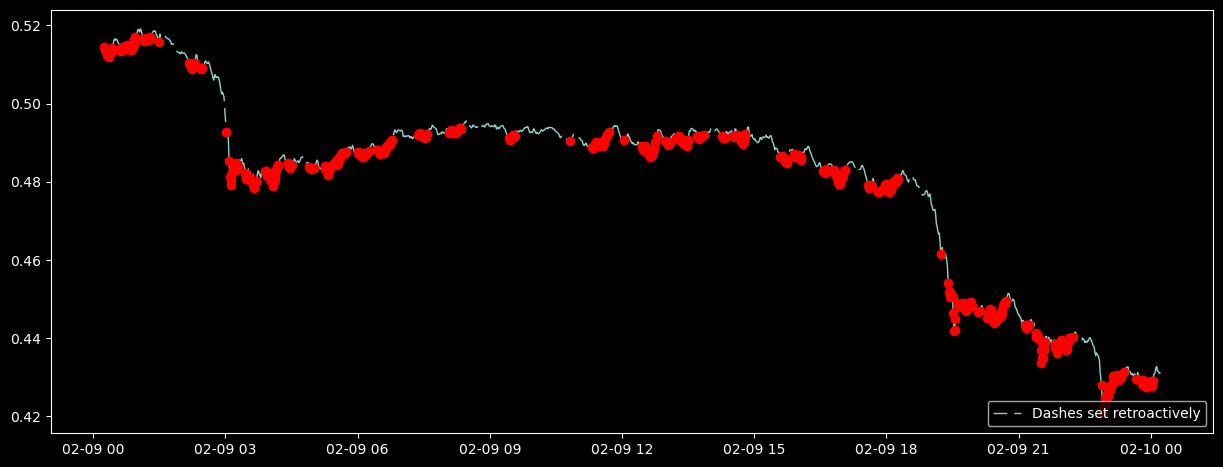

90/90 [==============================] - 4s 11ms/step
Buy Mean: : 37.753%
ModelAccuracy: 61.200%
True Win Predictions Mean of all: 11.445%
XXX Loss Buy Mean of all: 12.491%
Missed good deal off all: 26.308%
Good Zero prediction Mean: 49.756%
good fiability
========= Win Ratio:47.815006684491976 %====================
Precent Mean: 47.815%
Precent Mean: 47.815%


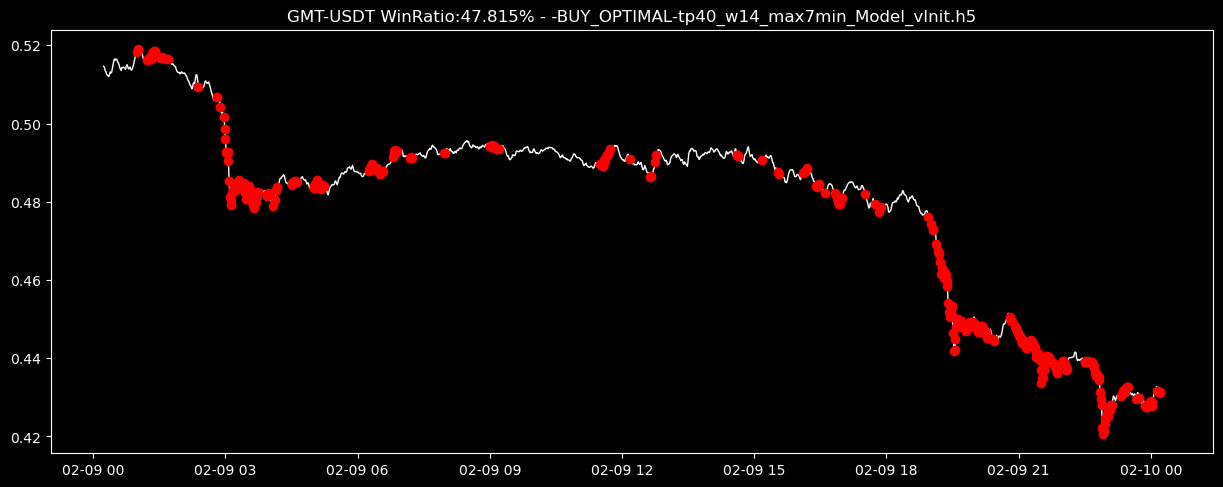

2981

In [649]:
# Model_FileName="/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re3.h5" #LTC ::80.99/0.86 # GMT: 84/0.93 LPT:86.9330453563715/0.8 ETH:78 #SOL 75/0.6 Doge:58/0.5


# # Model_FileName= "/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp349_w12_max12min_Model_VeryDeep.h5" # Win Ratio:47.11246200607903 # GMT  Win Ratio:57.608695652173914
# #Model_FileName= "/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp250_w12_max12min_Model_VeryDeep.h5" # Win Ratio:42.80420927819772 #GMT Win Ratio:53.
# #Model_FileName="/UltimeTradingBot/Data/BUY_TEST/tp180_w12_max12min_Model_VeryDeep.h5" # Win Ratio:59.35050391937291 # GMT 61.70886075949367/9 #SNM 52% / ETH 59.8/2
# #Model_FileName="/UltimeTradingBot/Data/BUY_TEST/tp70_w12_max12min_Model_VeryDeep.h5" # %44
# # Model_FileName="/UltimeTradingBot/Data/BUY_TEST/tp300_w12_max60min_Model_true_win_model_v2.h5" #45%
# #Model_FileName="/UltimeTradingBot/Data/BUY_TEST/tp300_w12_max60min_Model_VeryDeep.h5" #46%

Model_FileName="/UltimeTradingBot/Data/BUY_OPTIMAL/tp40_w14_max7min_Model_vInit.h5"
USED_MODEL=load_model(Model_FileName)


## Ploting original
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5.5)

x = np.linspace(0, 10, 500)
dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off

fig, ax = plt.subplots()
line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                 label='Dashes set retroactively')
line1.set_dashes(dashes)
plt.plot(OnePair_DF[i_start:i_end][OnePair_DF.buy[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][OnePair_DF.buy[i_start:i_end]==1].price, 'ro')


ax.legend(loc='lower right')
plt.show()




OnePair_PredNote=USED_MODEL.predict( OnePair_DT[:, 0:-1])
OnePair_Pred=OnePair_PredNote.round()

gc.collect()

Original_Traget_Data=OnePair_DT[:,-1]
buy_mean=hp(Original_Traget_Data.mean(),"Buy Mean: ")
Predicted_Data=OnePair_Pred[:,0]
gc.collect()
TruePred=(Original_Traget_Data==Predicted_Data).copy()
ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")
gc.collect()
TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")
gc.collect()
LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")
gc.collect()

MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")
gc.collect()

GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")
gc.collect()

fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")
winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)

print(f"========= Win Ratio:{winratio*100} %====================")
TestsHistory.loc[len(TestsHistory)]=[Model_FileName,pair_to_test ,ModelAccuracy, TrueWinPred_Mean, LossPred_Mean, MissedDeal_Mean, GoodZero_Mean, WINDOW_SIZE,MAX_FORCAST_SIZE,TAKE_PROFIT,hp(winratio),buy_mean]


PREDICTION_TO_TEST=Predicted_Data

mname=Model_FileName.replace("/UltimeTradingBot/Data","")
coin=pair_to_test.replace('/','-')
mtitle=f"{coin} WinRatio:{hp(winratio)}% - {mname}".replace("/","-")

x = np.linspace(0, 10, 500)
dashes = []  # 10 points on, 5 off, 100 on, 5 off
fig, ax = plt.subplots()
line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                 label='price',c="w")
line1.set_dashes(dashes)
plt.plot(OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].price, 'ro',c="g")
plt.title(mtitle)

plt.show()
gc.collect()

In [ ]:
TestsHistory= pd.DataFrame(columns= ['Model-FileName','TestedPair' ,'ModelAccuracy', 'TrueWin', 'XLoss', 'MissedDeal', 'GoodZero', 'WINDOW','MAX_FORCAST_SIZE','TAKE_PROFIT','WinRatio','BuyMean'])

In [ ]:
## Generate Data
BAD_PERIOD_START="2022-08-30"
BAD_PERIOD_END="2022-11-22"
MAX_FORCAST_SIZE=16

# ai_options
WINDOW_SIZE= 7

start_period = datetime.strptime(PERIODE_START, '%d-%m-%Y %H:%M:%S')
end_period = datetime.strptime(PERIODE_END, '%d-%m-%Y %H:%M:%S')


#trading_options:
TAKE_PROFIT= 0.4
STOP_LOSS=  1.3  
MAX_HOLDING_TIME= MAX_FORCAST_SIZE

USE_TRAILING_STOP_LOSS: False
TRAILING_STOP_LOSS= .002     
TRAILING_TAKE_PROFIT= .002  





loc_start=0
loc_end=1000000


i_start=0
i_end=i_start+1000

# loc_start=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_START))
# loc_end=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_END))


Model_FileNames=["/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re3.h5" #LTC ::80.99/0.86 # GMT: 84/0.93 LPT:86.9330453563715/0.8 ETH:78 #SOL 75/0.6 Doge:58/0.5
,"/UltimeTradingBot/Data/BUY_TEST/tp30_w7_max2min_Model_VeryDeep.h5"   #52.500060887990465/21 ETC:51.307/16
,"/UltimeTradingBot/Data/BUY_TEST/tp30_w7_max2min_Model_true_win_model_Re1.h5"   #GMT 65.888/2% -  ETh: 55.0/0.37 -LTC 54/1.8
,"/UltimeTradingBot/Data/BUY_TEST/tp30_w7_max2min_Model_true_win_model_Re2.h5"
,"/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re2.h5" #LTC: 64/4
,"/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re1.h5" #LTC: 57.15/7.9
,"/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_VeryDeep.h5" #LTC:48.741696716644526/12
,"/UltimeTradingBot/Data/BUY_MIN_CLOSE/tp70_w7_max4min_Model_vInit.h5" #
,"/UltimeTradingBot/Data/BUY_MIN_CLOSE/tp70_w7_max4min_Model_true_win_model_Re1.h5" #Doge:28/4.5
,"/UltimeTradingBot/Data/BUY_MIN_CLOSE/tp70_w7_max4min_Model_true_win_model_Re2.h5" #Doge:32/4.0
,"/UltimeTradingBot/Data/BUY_MIN_CLOSE/tp70_w7_max4min_Model_true_win_model_Re3.h5" #Doge:34.17/3.8 GMT35
,"/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re2.h5" #LTC ::80.99/0.86 # GMT: 84/0.93 LPT:86.9330453563715/0.8 ETH:78 #SOL 75/0.6 Doge:58/0.5
,"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp42_w7_max16min_Model_true_win_model_Re3.h5" #GMT 44/
,"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp42_w7_max16min_Model_JUSTGood_v2.h5"
,"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp42_w7_max16min_Model_JUSTGood_v2.h5" # GMT:58/8
,"/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re2.h5" #58/6
,"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp130_w7_max16min_Model_true_win_model_Re7.h5",
"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp130_w7_max16min_Anti-Model_v2.h5"

]

Model_FileNames=["/UltimeTradingBot/Data/BUY_TEST/tp92_w7_max3min_Model_true_win_model_Re4.h5",
                 "/UltimeTradingBot/Data/BUY_TEST/tp92_w7_max3min_Model_true_win_model_Re4.h5",
                 "/UltimeTradingBot/Data/BUY_TEST/tp92_w7_max3min_Model_VeryDeep.h5",
                 "/UltimeTradingBot/Data/BUY_TEST/tp92_w7_max3min_Model_vInit.h5"]

Model_FileNames=["/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re3.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re4.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re2.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re1.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_VeryDeep.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_vInit.h5"
    
]


Model_FileNames=matching_files
for pair_to_test in ["GMT/USDT","XRP/USDT","ETH/USDT","LTC/USDT","SOL/USDT"]:
    coin=pair_to_test
    loc_start=df_list1m[coin].index.get_loc(day)
    loc_end=df_list1m[coin].index.get_loc(day+pd.Timedelta('1 day'))
    print(f'#################################################### Working on : {pair_to_test} ###################################################')
    OnePair_DF=mini_expand4(        pair=pair_to_test,
                                    i=loc_start,j=loc_end,
                                    window=WINDOW_SIZE,
                                    metadata=MetaData,
                                    high_weight=1,
                                    buy_pourcent=TAKE_PROFIT,
                                    sell_pourcent=STOP_LOSS,
                                    buy_function=buy_test
                            )
    OnePair_DT=OnePair_DF.to_numpy()
    gc.collect()
    OnePair_DT=fixdt(OnePair_DT)
    print(OnePair_DT[0,0] == OnePair_DF.iloc[0,0])
    print(OnePair_DT[5,5] == OnePair_DF.iloc[5,5])
    hp(OnePair_DF.buy.mean(),"Buy mean percent")
    x = np.linspace(0, 10, 500)
    dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off

    fig, ax = plt.subplots()
    line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                    label='Dashes set retroactively')
    line1.set_dashes(dashes)
    plt.plot(OnePair_DF[i_start:i_end][OnePair_DF.buy[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][OnePair_DF.buy[i_start:i_end]==1].price, 'ro')


    ax.legend(loc='lower right')
    plt.show()


    for Model_FileName in Model_FileNames:
        print(f'Using Model:{Model_FileName}')
        USED_MODEL=load_model(Model_FileName)

  


        OnePair_PredNote=USED_MODEL.predict( OnePair_DT[:, 0:-1])
        OnePair_Pred=OnePair_PredNote.round()

        gc.collect()

        Original_Traget_Data=OnePair_DT[:,-1]
        buy_mean=hp(Original_Traget_Data.mean(),"Buy Mean: ")
        Predicted_Data=OnePair_Pred[:,0]
        gc.collect()
        TruePred=(Original_Traget_Data==Predicted_Data).copy()
        ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")
        gc.collect()
        TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
        TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")
        gc.collect()
        LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
        LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")
        gc.collect()

        MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
        MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")
        gc.collect()

        GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
        GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")
        gc.collect()

        fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
        if( fiability == 100):print("good fiability")
        else: print(f"check the fiability {fiability}")
        winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)

        print(f"========= Win Ratio:{winratio*100} %====================")
        TestsHistory.loc[len(TestsHistory)]=[Model_FileName,pair_to_test ,ModelAccuracy, TrueWinPred_Mean, LossPred_Mean, MissedDeal_Mean, GoodZero_Mean, WINDOW_SIZE,MAX_FORCAST_SIZE,TAKE_PROFIT,hp(winratio),buy_mean]
        TestsHistory.to_csv("Plots/mini-results.csv")

        PREDICTION_TO_TEST=Predicted_Data

        x = np.linspace(0, 10, 500)
        dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off
        fig, ax = plt.subplots()
        line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                        label='price')
        line1.set_dashes(dashes)
        plt.plot(OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].price, 'ro')
        mname=Model_FileName.replace("/UltimeTradingBot/Data","")
        mtitle=f"{coin} - {mname}".replace("/","-")
        plt.title(mtitle)
        plt.savefig(f"Plots/{mtitle}.png")        
        plt.show()
        gc.collect()

In [ ]:
TestsHistory2=TestsHistory

In [ ]:
TestsHistory=pd.read_csv("test-restuls01.csv",index_col=0)

In [ ]:
# TestsHistory.sort_values("WinRatio",ascending=0)[:30]
TestsHistory.sort_values("TestedPair",ascending=0)[:30]

In [ ]:
TestsHistory.sort_values("TrueWin",ascending=0)[:20]

In [ ]:
TestsHistory.groupby("Model-FileName").mean().sort_values("WinRatio",ascending=0)[:10]

In [ ]:
TestsHistory.groupby("Model-FileName").mean().sort_values("WinRatio",ascending=0)[:10]

# Test MultiModel sollution

In [ ]:

bag_of_modules=["/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp130_w7_max16min_Anti-Model_v2.h5",
               "/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp130_w7_max16min_Model_VeryDeep.h5",
               "/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp42_w7_max16min_Model_vInit.h5",
               "/UltimeTradingBot/Data/SELL_TEST/tp70_w7_max3min_Model_vInit.h5",
               #"/UltimeTradingBot/Data/BUY_TEST/tp150_w7_max2min_Model_true_win_model_v3.h5", 
               #"/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re1.h5"
               ]

bag_of_modules=[
                "/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp130_w7_max16min_Model_vInit.h5",
                #"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp130_w7_max16min_Model_true_win_model_Re8.h5",
                #"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp130_w7_max16min_Anti-Model_v2.h5",
                #"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp42_w7_max16min_Model_vInit.h5",
                "/UltimeTradingBot/Data/BUY_MIN_CLOSE/tp70_w7_max4min_Model_VeryDeep.h5",
                "/UltimeTradingBot/Data/BUY_TEST/tp150_w7_max2min_Model_vInit.h5",  
 #               "/UltimeTradingBot/Data/SELL_TEST/tp250_w7_max16min_Model_vInit.h5", 
 #               "/UltimeTradingBot/Data/SELL_TEST/tp25_w7_max1min_Anti-Model_v2.h5",               
                ]

bag_of_modules=[
                # "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re3.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re4.h5",
                #  "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re2.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re1.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_VeryDeep.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_vInit.h5"
    
]

aditive_models=["/UltimeTradingBot/Data/SELL_TEST/tp25_w7_max1min_Model_vInit.h5",
                "/UltimeTradingBot/Data/SELL_TEST/tp25_w7_max1min_Anti-Model_v2.h5",
                "/UltimeTradingBot/Data/SELL_TEST/tp40_w7_max3min_Anti-Model_v2.h5",
                "/UltimeTradingBot/Data/SELL_TEST/tp40_w7_max3min_Model_BadVeryDeep_v2.h5",
                "/UltimeTradingBot/Data/SELL_TEST/tp250_w7_max16min_Model_VeryDeep.h5",
                "/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_v5.h5",  
                "/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re3.h5",
                "/UltimeTradingBot/Data/SELL_TEST/tp70_w7_max3min_Model_vInit.h5",
                
                              
                ]
aditive_models=[]
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 500)
dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off

fig, ax = plt.subplots()
line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                 label='Dashes set retroactively')
line1.set_dashes(dashes)
plt.plot(OnePair_DF[i_start:i_end][OnePair_DF.buy[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][OnePair_DF.buy[i_start:i_end]==1].price, 'ro')


ax.legend(loc='lower right')
plt.show()

OnePair_Pred=1
if aditive_models:
    for Model_FileName in aditive_models:
        USED_MODEL=load_model(Model_FileName)
        OnePair_PredNote=USED_MODEL.predict( OnePair_DT[:, 0:-1])
        OnePair_Pred=(OnePair_PredNote.round()==1)|(OnePair_Pred==1)
if bag_of_modules:
    for Model_FileName in bag_of_modules:
        USED_MODEL=load_model(Model_FileName)
        OnePair_PredNote=USED_MODEL.predict( OnePair_DT[:, 0:-1])
        OnePair_Pred=OnePair_PredNote.round()*OnePair_Pred

gc.collect()

Original_Traget_Data=OnePair_DT[:,-1]
buy_mean=hp(Original_Traget_Data.mean(),"Buy Mean: ")
Predicted_Data=OnePair_Pred[:,0]
gc.collect()
TruePred=(Original_Traget_Data==Predicted_Data).copy()
ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")
gc.collect()
TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")
gc.collect()
LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")
gc.collect()

MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")
gc.collect()

GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")
gc.collect()

fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")
winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)

print(f"========= Win Ratio:{winratio*100} %====================")
TestsHistory.loc[len(TestsHistory)]=[Model_FileName,pair_to_test ,ModelAccuracy, TrueWinPred_Mean, LossPred_Mean, MissedDeal_Mean, GoodZero_Mean, WINDOW_SIZE,MAX_FORCAST_SIZE,TAKE_PROFIT,hp(winratio),buy_mean]


PREDICTION_TO_TEST=Predicted_Data

x = np.linspace(0, 10, 500)
dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off
fig, ax = plt.subplots()
line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                 label='price')
line1.set_dashes(dashes)
plt.plot(OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].price, 'ro')


ax.legend(loc='lower right')
plt.show()
gc.collect()

In [ ]:
ii_start=49000
ii_end=ii_start+1000
x = np.linspace(0, 10, 500)
dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off
fig, ax = plt.subplots()
line1, = ax.plot(OnePair_DF.index[ii_start:ii_end], OnePair_DF.price[ii_start:ii_end], '-', linewidth=1,
                 label='price')
line1.set_dashes(dashes)
plt.plot(OnePair_DF[ii_start:ii_end][PREDICTION_TO_TEST[ii_start:ii_end]==1].index, OnePair_DF[ii_start:ii_end][PREDICTION_TO_TEST[ii_start:ii_end]==1].price, 'ro')


ax.legend(loc='lower right')
plt.show()
gc.collect()

In [ ]:
ii_start=46000
ii_end=ii_start+600
x = np.linspace(0, 10, 500)
dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off
fig, ax = plt.subplots()
line1, = ax.plot(OnePair_DF.index[ii_start:ii_end], OnePair_DF.price[ii_start:ii_end], '-', linewidth=1,
                 label='price')
line1.set_dashes(dashes)
plt.plot(OnePair_DF[ii_start:ii_end][PREDICTION_TO_TEST[ii_start:ii_end]==1].index, OnePair_DF[ii_start:ii_end][PREDICTION_TO_TEST[ii_start:ii_end]==1].price, 'ro')


# ax.legend(loc='lower right')

plt.show()
gc.collect()

In [ ]:
!ls Plots

In [ ]:
press=-0.37
OnePair_Pred=(OnePair_PredNote+press).round()
gc.collect()

Original_Traget_Data=OnePair_DT[:,-1]
buy_mean=hp(Original_Traget_Data.mean(),"Buy Mean: ")
Predicted_Data=OnePair_Pred[:,0]
gc.collect()
TruePred=(Original_Traget_Data==Predicted_Data).copy()
ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")
gc.collect()
TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")
gc.collect()
LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")
gc.collect()

MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")
gc.collect()

GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")
gc.collect()

fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")
winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)

print(f"========= Win Ratio:{winratio*100} %====================")
TestsHistory.loc[len(TestsHistory)]=[Model_FileName,pair_to_test ,ModelAccuracy, TrueWinPred_Mean, LossPred_Mean, MissedDeal_Mean, GoodZero_Mean, WINDOW_SIZE,MAX_FORCAST_SIZE,TAKE_PROFIT,hp(winratio),buy_mean]


PREDICTION_TO_TEST=Predicted_Data

x = np.linspace(0, 10, 500)
dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off
fig, ax = plt.subplots()
line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                 label='price')
line1.set_dashes(dashes)
plt.plot(OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].price, 'ro')


ax.legend(loc='lower right')
plt.show()
gc.collect()

In [ ]:
TestsHistory[TestsHistory.WinRatio==78.558]["Model-FileName"].values

In [ ]:
TestsHistory[TestsHistory.WinRatio==60.909]

In [ ]:
TestsHistory.to_csv("test-restuls02.csv")

In [ ]:
import os
import glob

path = "/UltimeTradingBot/Data"
pattern = os.path.join(path, "**/*w7*.h5")

matching_files = []
for file_path in glob.iglob(pattern, recursive=True):
    if os.path.isfile(file_path):
        matching_files.append(file_path)

print(matching_files)